
# TileDB-SOMA / SpatialData Compatibility Issue

## Setup

Import `tiledbsoma` and other necessary libraries.

In [1]:
import json
import tempfile
from pathlib import Path
import spatialdata as sd
import spatialdata_plot

from scanpy.datasets._datasets import (
    _download_visium_dataset as download_visium_dataset,
)

import tiledbsoma
import tiledbsoma.io.spatial

tiledbsoma.show_package_versions()

/Users/aaronwolen/repos/uv-soma-test/.venv/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


tiledbsoma.__version__              1.15.0rc0.post233.dev1833511662
TileDB core version (libtiledbsoma) 2.27.0
python version                      3.9.21.final.0
OS version                          Darwin 24.2.0


Load dataset info from `config.json`. 

In [2]:
with open("../config.json", "r") as f:
    config = json.load(f)

dataset = config["datasets"][0]
dataset

{'experiment_name': 'CytAssist_FFPE_Mouse_Brain_Rep2',
 'spaceranger_version': '2.0.0'}

SOMA experiment parameters.

In [3]:
MEASUREMENT_NAME = "RNA"  # Dataset modality name
SCENE_NAME = "scene0"  # Name of scene where spatial data is stored

## Download and inspect the data

In [4]:
data_dir = Path(config["data_dir"])
if not data_dir.exists():
    data_dir.mkdir()

dataset_dir = download_visium_dataset(
    sample_id=dataset["experiment_name"],  # type: ignore
    spaceranger_version=dataset["spaceranger_version"],  # type: ignore
    base_dir=data_dir,
)

## Dataset directory structure

Take a look at the structure of the downloaded dataset.

In [5]:
!tree {dataset_dir}

data/CytAssist_FFPE_Mouse_Brain_Rep2
├── CytAssist_FFPE_Mouse_Brain_Rep2_spatial.tar.gz
├── filtered_feature_bc_matrix.h5
└── spatial
    ├── aligned_fiducials.jpg
    ├── aligned_tissue_image.jpg
    ├── cytassist_image.tiff
    ├── detected_tissue_image.jpg
    ├── scalefactors_json.json
    ├── spatial_enrichment.csv
    ├── tissue_hires_image.png
    ├── tissue_lowres_image.png
    └── tissue_positions.csv

2 directories, 11 files


## Ingest

Construct the URI where the new SOMA experiment will be created.

In [9]:
experiment_uri = tempfile.mkdtemp(prefix=f"soma-{dataset['experiment_name']}-")
experiment_uri

'/var/folders/nr/1dsl0n155wj7wv083km8t1540000gn/T/soma-CytAssist_FFPE_Mouse_Brain_Rep2-h4ttq1qx'

In [10]:
tiledbsoma.io.spatial.from_visium(
    experiment_uri=experiment_uri,
    input_path=dataset_dir,
    measurement_name=MEASUREMENT_NAME,
    scene_name=SCENE_NAME,
    image_channel_first=True,
    write_obs_spatial_presence=True,
)

/var/folders/nr/1dsl0n155wj7wv083km8t1540000gn/T/ipykernel_40002/2929869416.py:1: UserWarning: Support for spatial types is experimental. Changes to both the API and data storage may not be backwards compatible.
  tiledbsoma.io.spatial.from_visium(


'/var/folders/nr/1dsl0n155wj7wv083km8t1540000gn/T/soma-CytAssist_FFPE_Mouse_Brain_Rep2-h4ttq1qx'

Once the ingestion completes successfully, you can open the new SOMA experiment to begin exploring the data.

In [11]:
with tiledbsoma.Experiment.open(experiment_uri) as exp:
    print(exp)

<Experiment 'file:///var/folders/nr/1dsl0n155wj7wv083km8t1540000gn/T/soma-CytAssist_FFPE_Mouse_Brain_Rep2-h4ttq1qx' (open for 'r') (4 items)
    'ms': 'file:///var/folders/nr/1dsl0n155wj7wv083km8t1540000gn/T/soma-CytAssist_FFPE_Mouse_Brain_Rep2-h4ttq1qx/ms' (unopened)
    'obs': 'file:///var/folders/nr/1dsl0n155wj7wv083km8t1540000gn/T/soma-CytAssist_FFPE_Mouse_Brain_Rep2-h4ttq1qx/obs' (unopened)
    'obs_spatial_presence': 'file:///var/folders/nr/1dsl0n155wj7wv083km8t1540000gn/T/soma-CytAssist_FFPE_Mouse_Brain_Rep2-h4ttq1qx/obs_spatial_presence' (unopened)
    'spatial': 'file:///var/folders/nr/1dsl0n155wj7wv083km8t1540000gn/T/soma-CytAssist_FFPE_Mouse_Brain_Rep2-h4ttq1qx/spatial' (unopened)>


## SpatialData export

In [13]:
with tiledbsoma.Experiment.open(experiment_uri) as exp:
    with exp.axis_query(
        measurement_name=MEASUREMENT_NAME,
    ) as query:
        sdata = query.to_spatialdata(X_name="data")

/Users/aaronwolen/repos/uv-soma-test/.venv/lib/python3.9/site-packages/tiledbsoma/_query.py:540: UserWarning: Support for spatial types is experimental. Changes to both the API and data storage may not be backwards compatible.
  warnings.warn(SPATIAL_DISCLAIMER)
/Users/aaronwolen/repos/uv-soma-test/.venv/lib/python3.9/site-packages/spatialdata/models/models.py:1035: UserWarning: Converting `region_key: region_key` to categorical dtype.
  return convert_region_column_to_categorical(adata)


Manually fix obs/var index names since `query.to_anndata()` doesn't support the `obs_id_name` and `var_id_name` arguments.

In [ ]:
sdata.tables[MEASUREMENT_NAME].obs.set_index("obs_id", inplace=True)
sdata.tables[MEASUREMENT_NAME].var.set_index("var_id", inplace=True)

## Data

### Tables

In [24]:
sdata.tables[MEASUREMENT_NAME].obs

,soma_joinid,region_key,instance_key
obs_id,,,
AACACTTGGCAAGGAA-1,0,scene0_loc,1201
AACAGGATTCATAGTT-1,1,scene0_loc,246
AACAGGTTATTGCACC-1,2,scene0_loc,1646
AACAGGTTCACCGAAG-1,3,scene0_loc,238
AACCAAGGTATCAGGC-1,4,scene0_loc,2172
...,...,...,...
TGTTGCGTCCAAGATT-1,2230,scene0_loc,875
TGTTGGAACCTTCCGC-1,2231,scene0_loc,297
TGTTGGAACGAGGTCA-1,2232,scene0_loc,1305


In [25]:
sdata.tables[MEASUREMENT_NAME].var

,soma_joinid,gene_ids,feature_types,genome
var_id,,,,
Xkr4,0,ENSMUSG00000051951,Gene Expression,mm10
Rp1,1,ENSMUSG00000025900,Gene Expression,mm10
Sox17,2,ENSMUSG00000025902,Gene Expression,mm10
Lypla1,3,ENSMUSG00000025903,Gene Expression,mm10
Tcea1,4,ENSMUSG00000033813,Gene Expression,mm10
...,...,...,...,...
Zfy2,19460,ENSMUSG00000000103,Gene Expression,mm10
Sry,19461,ENSMUSG00000069036,Gene Expression,mm10
Gm4064,19462,ENSMUSG00000102053,Gene Expression,mm10


## Visualize

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4625..1.0].


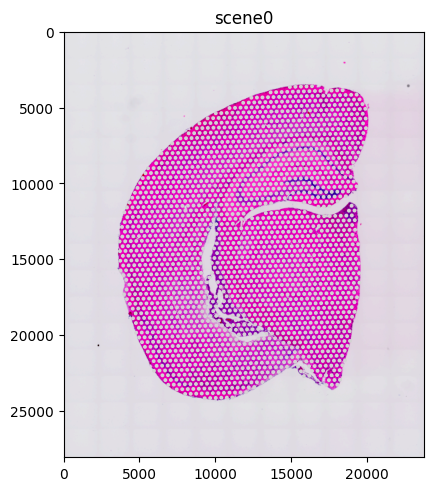

In [14]:
sdata.pl.render_images().pl.render_shapes().pl.show("scene0")

In [26]:
sdata["RNA"].to_df().sum(axis=0).sort_values(ascending=False).head(10)

var_id
Ttr        667081.0
Fth1       108798.0
Camk2n1    104989.0
Atp1b1     101138.0
Snap25      99798.0
Calm1       82299.0
App         80407.0
Mbp         77770.0
Olfm1       71877.0
Tmsb4x      71351.0
dtype: float32

/var/folders/nr/1dsl0n155wj7wv083km8t1540000gn/T/ipykernel_40002/590951764.py:2: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_images.render_images` in spatialdata_plot version version 0.3.0, switch to `element` instead.
  sdata.pl.render_images(elements="scene0_tissue")
/var/folders/nr/1dsl0n155wj7wv083km8t1540000gn/T/ipykernel_40002/590951764.py:2: DeprecationWarning: `elements` is being deprecated as an argument to `PlotAccessor.render_shapes.render_shapes` in spatialdata_plot version 0.3.0, switch to `element` instead.
  sdata.pl.render_images(elements="scene0_tissue")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4625..1.0].


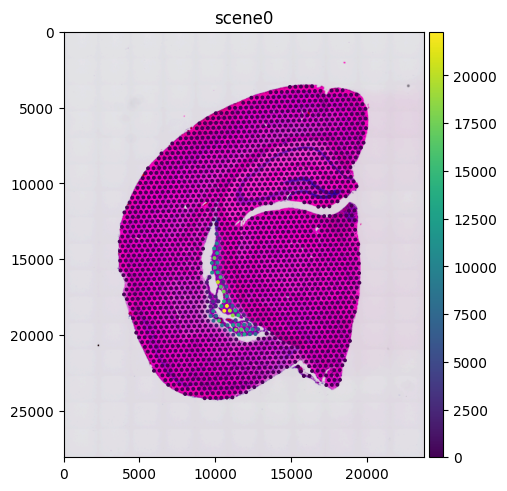

In [27]:
(
    sdata.pl.render_images(elements="scene0_tissue")
    .pl.render_shapes(elements="scene0_loc", color="Ttr")
    .pl.show()
)

In [28]:
sdata.tables[MEASUREMENT_NAME].uns

OrderedDict([('spatialdata_attrs',
              {'region': ['scene0_loc'],
               'region_key': 'region_key',
               'instance_key': 'instance_key'})])

## Table

### obs

In [43]:
sdata.tables["RNA"].obs

""
obs_id
AACACTTGGCAAGGAA-1
AACAGGATTCATAGTT-1
AACAGGTTATTGCACC-1
AACAGGTTCACCGAAG-1
AACCAAGGTATCAGGC-1
...
TGTTGCGTCCAAGATT-1
TGTTGGAACCTTCCGC-1
TGTTGGAACGAGGTCA-1


In [44]:
sdata.tables["RNA"].uns

OrderedDict()